In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *


/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)
n_rct_before_split = 10**4
n_host = 200
n_mirror = 500
n_cand2 = 500

power_x, power_x_t = 1, 1
causal_param_first_index = 3
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 10 * T + 10* X[:,0]*T + 10* X[:,1]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.randint(0, 2, size= n_rct_before_split)
X1 = np.random.normal(size=n_rct_before_split)
x_distributions= {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + 2*X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 2*X_1 + eps)

In [3]:
X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, n_mirror, power_x, power_x_t, outcome_function, std_true_y)

pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2, \
                                    power_x, power_x_t, outcome_function, std_true_y)

X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

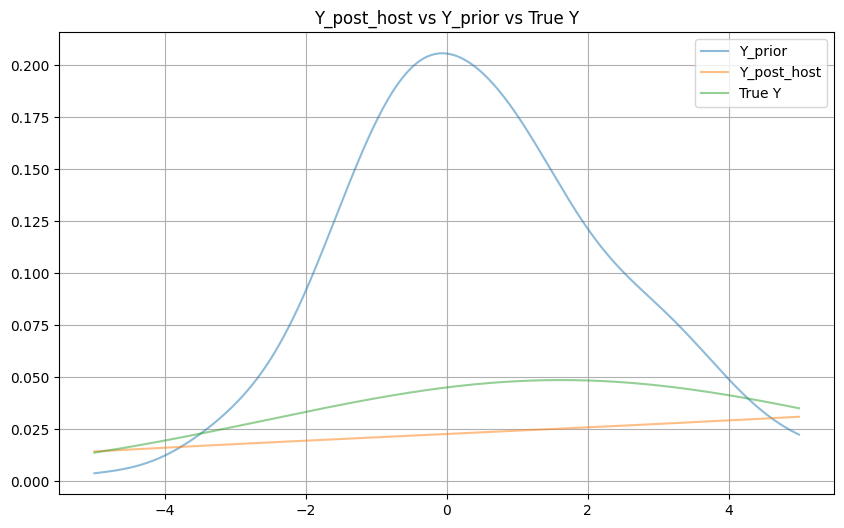

In [4]:
# Initialize prior parameters
post_mean = np.array([1, 0.5, 2, -1, 0, -3])
beta_0, sigma_0_sq = post_mean, 1
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


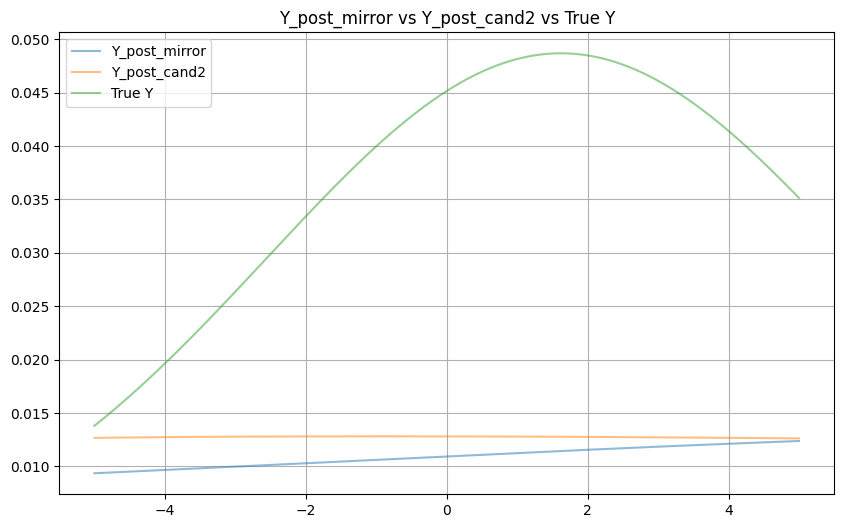

In [5]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

## With candidate = mirror dataset
bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [6]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 20
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 10
max_tree_depth = 7
sigma_rand_error = 1

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 130/130 [00:01, 121.47it/s, step size=9.47e-02, acc. prob=0.725]

Inference ran for 0.02 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      2.03      0.12      2.03      1.82      2.19    113.06      0.99
    beta_1     -0.74      0.22     -0.72     -1.10     -0.39     45.64      1.00
    beta_2      0.06      0.10      0.06     -0.12      0.20    209.19      0.99
    beta_3     19.83      0.15     19.82     19.61     20.09     79.30      1.00
    beta_4      9.61      0.31      9.61      8.98     10.00     37.09      1.00
    beta_5      0.25      0.15      0.26      0.05      0.49    121.29      0.99

Number of divergences: 0


In [7]:
beta_post_host.describe()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2.032109,-0.741141,0.059101,19.827069,9.606724,0.253379
std,0.120688,0.219385,0.098762,0.150441,0.311286,0.152846
min,1.716906,-1.291951,-0.147441,19.428482,8.894959,-0.167322
25%,1.945801,-0.883994,-0.011214,19.714717,9.400728,0.139536
50%,2.028501,-0.712846,0.055894,19.825999,9.613717,0.261619
75%,2.115245,-0.617447,0.127001,19.933349,9.795378,0.371996
max,2.328332,-0.104723,0.331584,20.166990,10.370366,0.598642


### 3. Calculating EIG observational

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [8]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [9]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

10.378138148509152

Now to calculate for the causal

In [10]:
sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [11]:
pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

Sample: 100%|██████████| 110/110 [00:00, 199.26it/s, step size=5.69e-02, acc. prob=0.931]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 218.59it/s, step size=6.04e-02, acc. prob=0.909]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 200.66it/s, step size=5.00e-02, acc. prob=0.951]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 239.43it/s, step size=5.59e-02, acc. prob=0.929]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 225.21it/s, step size=5.95e-02, acc. prob=0.923]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 294.55it/s, step size=8.86e-02, acc. prob=0.834]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 280.31it/s, step size=7.49e-02, acc. prob=0.869]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 356.23it/s, step size=9.23e-02, acc. prob=0.798]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 229.09it/s, step size=6.67e-02, acc. prob=0.910]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 240.62it/s, step size=6.94e-02, acc. prob=0.890]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 218.76it/s, step size=6.70e-02, acc. prob=0.916]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 219.27it/s, step size=6.05e-02, acc. prob=0.903]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 228.89it/s, step size=6.05e-02, acc. prob=0.912]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 228.17it/s, step size=6.25e-02, acc. prob=0.915]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 287.88it/s, step size=7.98e-02, acc. prob=0.855]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 224.17it/s, step size=6.05e-02, acc. prob=0.913]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 155.26it/s, step size=4.12e-02, acc. prob=0.967]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 205.19it/s, step size=7.66e-02, acc. prob=0.879]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 198.25it/s, step size=5.48e-02, acc. prob=0.944]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 284.87it/s, step size=7.86e-02, acc. prob=0.857]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 196.72it/s, step size=6.59e-02, acc. prob=0.922]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 254.67it/s, step size=9.03e-02, acc. prob=0.793]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 202.56it/s, step size=5.96e-02, acc. prob=0.916]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 197.62it/s, step size=5.74e-02, acc. prob=0.934]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 201.16it/s, step size=8.11e-02, acc. prob=0.843]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 210.06it/s, step size=6.06e-02, acc. prob=0.909]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 285.84it/s, step size=8.85e-02, acc. prob=0.825]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 201.48it/s, step size=6.02e-02, acc. prob=0.940]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 199.06it/s, step size=5.26e-02, acc. prob=0.948]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 204.35it/s, step size=6.05e-02, acc. prob=0.942]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 285.62it/s, step size=8.51e-02, acc. prob=0.778]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 191.74it/s, step size=6.05e-02, acc. prob=0.922]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 223.24it/s, step size=6.07e-02, acc. prob=0.924]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 212.78it/s, step size=6.05e-02, acc. prob=0.920]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 218.95it/s, step size=6.63e-02, acc. prob=0.904]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 181.04it/s, step size=6.05e-02, acc. prob=0.923]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 167.39it/s, step size=5.03e-02, acc. prob=0.943]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 197.53it/s, step size=5.69e-02, acc. prob=0.926]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 205.51it/s, step size=5.59e-02, acc. prob=0.937]


Inference ran for 0.01 minutes


Sample: 100%|██████████| 110/110 [00:00, 194.50it/s, step size=6.01e-02, acc. prob=0.934]

Inference ran for 0.01 minutes


In [12]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

12.504919446643044

Now, trying to calculate in closed form

In [13]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

16.698401838483836

In [14]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

7.698727606738956

For the cand2 dataset

In [15]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [16]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

4.437864128236924

Now, trying to calculate in closed form

In [17]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

16.543071389037856

In [18]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

7.617095792472121